# Trading at the close

This is the firt attempt to create a model to predict the price of stocks for "Trading the close" Kaggle Problem.
The idea is to train a model to predict each stock price variation and then compute the target based on the predicted coeficient for the index


# Notebook Setup

In [5]:
import os

KAGGLE_DATA_PATH = '/home/fraverta/development/comp642-project/trading_the_close_data/train.csv'
PATH_TO_PICKLE_MODELS = '/home/fraverta/development/comp642-project/prophet-only-wap-model-per-stock-2'

os.makedirs(PATH_TO_PICKLE_MODELS, exist_ok=True)


# Load Data

In [6]:
import pandas as pd
import numpy as np
import os
from structlog import get_logger
import matplotlib.pyplot as plt


logger = get_logger()

In [7]:
data = pd.read_csv(KAGGLE_DATA_PATH)

# remplace wap nan by 1 
data['wap'] = data['wap'].fillna(1)

data = data.dropna(subset=['target'])

# remplace target nan by 1 
#data['target'] = data['wap'].fillna(1)

# sort the data by stock_id, date_id, seconds_in_bucket
data = data.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])

# sort the data by stock_id, date_id, seconds_in_bucket
data = data.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'])

# Create additional features
Based on https://www.kaggle.com/code/serhiikharchuk/lightgbm-xgboost-catboost

In [8]:
# Feature Engineering function
def generate_features(df):
    features = ['seconds_in_bucket', 'imbalance_buy_sell_flag', 'imbalance_size', 'matched_size',
                'bid_size', 'ask_size', 'reference_price', 'far_price', 'near_price', 'ask_price',
                'bid_price', 'wap', 'imb_s1', 'imb_s2']
    
    # Imbalance features
    df['imb_s1'] = (df['bid_size'] - df['ask_size']) / (df['bid_size'] + df['ask_size'])
    df['imb_s2'] = (df['imbalance_size'] - df['matched_size']) / (df['matched_size'] + df['imbalance_size'])
    
    # Price difference features
    prices = ['reference_price', 'far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    for i, a in enumerate(prices):
        for j, b in enumerate(prices[i+1:], i+1):
            df[f'{a}_{b}_diff'] = df[a] - df[b]
            features.append(f'{a}_{b}_diff')
    
    return df, features

data, features = generate_features(data)
data.fillna(0, inplace=True)
data


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,far_price_near_price_diff,far_price_ask_price_diff,far_price_bid_price_diff,far_price_wap_diff,near_price_ask_price_diff,near_price_bid_price_diff,near_price_wap_diff,ask_price_bid_price_diff,ask_price_wap_diff,bid_price_wap_diff
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000214,0.000026,-0.000188
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000764,0.000660,-0.000104
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000895,0.000298,-0.000597
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000215,0.000214,-0.000001
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000622,0.000016,-0.000606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,...,0.000000,-0.000700,-0.000583,-0.000594,-0.000700,-0.000583,-0.000594,0.000117,0.000106,-0.000011
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,...,-0.000257,-0.000771,-0.000514,-0.000690,-0.000514,-0.000257,-0.000433,0.000257,0.000081,-0.000176
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,...,0.000000,-0.000094,0.000000,-0.000008,-0.000094,0.000000,-0.000008,0.000094,0.000086,-0.000008
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,...,0.000000,0.000000,0.000240,0.000202,0.000000,0.000240,0.000202,0.000240,0.000202,-0.000038


## Some description about dataset

In [9]:
data.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'imb_s1', 'imb_s2',
       'reference_price_far_price_diff', 'reference_price_near_price_diff',
       'reference_price_ask_price_diff', 'reference_price_bid_price_diff',
       'reference_price_wap_diff', 'far_price_near_price_diff',
       'far_price_ask_price_diff', 'far_price_bid_price_diff',
       'far_price_wap_diff', 'near_price_ask_price_diff',
       'near_price_bid_price_diff', 'near_price_wap_diff',
       'ask_price_bid_price_diff', 'ask_price_wap_diff', 'bid_price_wap_diff'],
      dtype='object')

In [10]:
# Print data types
data.dtypes

stock_id                             int64
date_id                              int64
seconds_in_bucket                    int64
imbalance_size                     float64
imbalance_buy_sell_flag              int64
reference_price                    float64
matched_size                       float64
far_price                          float64
near_price                         float64
bid_price                          float64
bid_size                           float64
ask_price                          float64
ask_size                           float64
wap                                float64
target                             float64
time_id                              int64
row_id                              object
imb_s1                             float64
imb_s2                             float64
reference_price_far_price_diff     float64
reference_price_near_price_diff    float64
reference_price_ask_price_diff     float64
reference_price_bid_price_diff     float64
reference_p

In [11]:
data.count()

stock_id                           5237892
date_id                            5237892
seconds_in_bucket                  5237892
imbalance_size                     5237892
imbalance_buy_sell_flag            5237892
reference_price                    5237892
matched_size                       5237892
far_price                          5237892
near_price                         5237892
bid_price                          5237892
bid_size                           5237892
ask_price                          5237892
ask_size                           5237892
wap                                5237892
target                             5237892
time_id                            5237892
row_id                             5237892
imb_s1                             5237892
imb_s2                             5237892
reference_price_far_price_diff     5237892
reference_price_near_price_diff    5237892
reference_price_ask_price_diff     5237892
reference_price_bid_price_diff     5237892
reference_p

# Split data for training and validation

In [12]:
# split the data into train and validation
train_data = data.loc[data['date_id'] < 425]
test_data = data.loc[data['date_id'] >= 425]

# check the number of unique stock_ids in the train and validation set
#len(train['stock_id'].unique()), len(valid['stock_id'].unique())        

len(train_data), len(test_data)

(4621893, 615999)

# Baseline Models

## Baseline Model 1 
The baseline model suggested in the challenge instroduction is to predict 1 for target always


In [13]:
logger.info('Baseline model 1 accuracy train', MAE=(train_data['target']).abs().mean())
logger.info('Baseline model 1 accuracy test', MAE=(test_data['target']).abs().mean())

2024-04-05 18:31:33 [info     ] Baseline model 1 accuracy train MAE=6.4821212887954465
2024-04-05 18:31:33 [info     ] Baseline model 1 accuracy test MAE=5.8499123043254375


## Baseline Model 2

In [14]:
baseline_df_train = train_data.loc[:]
baseline_df_test = test_data.loc[:]

simple_mapping = {
    1: 0.1,
    0: 0,
    -1: -0.1
}

baseline_df_train['simple_prediction'] = baseline_df_train['imbalance_buy_sell_flag'].map(simple_mapping)
baseline_df_test['simple_prediction'] = baseline_df_test['imbalance_buy_sell_flag'].map(simple_mapping)

logger.info('Baseline model 2 accuracy train', MAE=(baseline_df_train['simple_prediction'] - baseline_df_train['target']).abs().mean())
logger.info('Baseline model 2 accuracy test', MAE=(baseline_df_test['simple_prediction'] - baseline_df_test['target']).abs().mean())

del baseline_df_train
del baseline_df_test

2024-04-05 18:31:34 [info     ] Baseline model 2 accuracy train MAE=6.481303604250602
2024-04-05 18:31:34 [info     ] Baseline model 2 accuracy test MAE=5.8499749700259205


# Guess the coeficients for the index

Here the assumption is the WAP_Index is a weighted average of the stocks's WAP, whose weights are constant
In this section, we are going to run a linear regression to guess this coefficients 

## Run the LR

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm
import polars as pl


def get_stock_index_coeficient(df):
    num_stocks = df["stock_id"].nunique()
    num_dates = df["date_id"].nunique()
    num_updates = df["seconds_in_bucket"].nunique()

    num_dates_map = {v:i for i, v in enumerate(sorted(df["date_id"].unique()))}

    print(f"# stocks         : {num_stocks}")
    print(f"# dates          : {num_dates}")
    print(f"# updates per day: {num_updates}")

    stock_returns = np.zeros((num_stocks, num_dates, num_updates))
    index_returns = np.zeros((num_stocks, num_dates, num_updates))


    for (stock_id, date_id), frame in tqdm(df.groupby(["stock_id", "date_id"])):
        frame["stock_return"] = ((frame["wap"] / frame["wap"].shift(6)).shift(-6) - 1) * 10_000
        frame["index_return"] = frame["stock_return"] - frame["target"]

        stock_returns[stock_id, num_dates_map[date_id]] = frame["stock_return"].values
        index_returns[stock_id, num_dates_map[date_id]] = frame["index_return"].values

    index_return = np.mean(index_returns, axis=0)

    lr = LinearRegression()
    y = index_return.reshape(-1)
    X = stock_returns.reshape((num_stocks, -1)).T

    mask = ~((np.isnan(y) | np.isnan(X).any(axis=1)))
    X, y = X[mask], y[mask]

    lr.fit(X, y)

    print(" Fit ".center(80, ">"))
    print("Coef:", lr.coef_)
    print("Intercept:", lr.intercept_)
    print("R2:", r2_score(y, lr.predict(X)))

    lr.coef_ = lr.coef_.round(3)
    lr.intercept_ = 0.0
    print(" Round with 3 digits ".center(80, ">"))
    print("Coef:", lr.coef_)
    print("Sum of Coef:", lr.coef_.sum())
    print("R2:", r2_score(y, lr.predict(X)))
    return lr.coef_


#coef_train = get_stock_index_coeficient(train_data)
#coef_validation = get_stock_index_coeficient(test_data)

On the graph below, we can see both coeficient for trainning and testing data are the same

In [16]:
coef_train = [0.004,0.00099987, 0.00200041, 0.00599891, 0.00400068, 0.00399949,
0.00200014, 0.0059992 , 0.00600029, 0.00200012, 0.00200072, 0.00800012,
0.00600039, 0.00200007, 0.0080014 , 0.00600051, 0.00199993, 0.0059999,
0.00400013, 0.00199974, 0.00399933, 0.00099993, 0.00599955, 0.00399971,
0.00199876, 0.00200008, 0.00400097, 0.0020008 , 0.00400021, 0.00400005,
0.00100001, 0.00100016, 0.00199924, 0.00199993, 0.00599995, 0.00399917,
0.00400017, 0.00399906, 0.00599977, 0.00200015, 0.0020007 , 0.03999955,
0.0020001 , 0.00199981, 0.00399968, 0.03999983, 0.00200033, 0.00099959,
0.00600002, 0.00399944, 0.00399979, 0.00600017, 0.00099921, 0.00399993,
0.00399936, 0.0019985 , 0.00599995, 0.00400028, 0.00599981, 0.00400045,
0.00600029, 0.00399988, 0.00200012, 0.00100003, 0.00200041, 0.00400043,
0.00200011, 0.00799989, 0.00400056, 0.00400011, 0.00199956, 0.00399921,
0.00599994, 0.00199992, 0.00399979, 0.00400047, 0.00200035, 0.00399996,
0.00400003, 0.00399989, 0.00100029, 0.00199997, 0.00200019, 0.00799969,
0.02000066, 0.00400029, 0.00600019, 0.00200024, 0.02      , 0.00199965,
0.00199968, 0.00599962, 0.00399987, 0.00199997, 0.00099953, 0.02000033,
0.00600029, 0.00099946, 0.00200062, 0.00399946, 0.00100021, 0.00199986,
0.00600047, 0.00600071, 0.00399889, 0.00600028, 0.0010003 , 0.00199986,
0.00400008, 0.00600071, 0.00600016, 0.00100013, 0.04000011, 0.00599947,
0.00200012, 0.00400061, 0.00199956, 0.00199961, 0.00599985, 0.00200055,
0.00200083, 0.00399993, 0.00599961, 0.00600028, 0.00200005, 0.00199999,
0.0080003 , 0.00600021, 0.00400044, 0.00199994, 0.00599988, 0.00200002,
0.00399908, 0.00600099, 0.00200021, 0.00399981, 0.00100042, 0.00399994,
0.00199993, 0.0039995 , 0.00800063, 0.00600055, 0.00799953, 0.00200005,
0.00400064, 0.00199988, 0.00099981, 0.00399912, 0.00399992, 0.00399974,
0.00599995, 0.00800022, 0.00400055, 0.00099968, 0.00099956, 0.00200017,
0.00599973, 0.00400059, 0.00100004, 0.00199961, 0.00599971, 0.00400006,
0.00599987, 0.00800007, 0.00200054, 0.00200102, 0.00400114, 0.00199923,
0.0399987 , 0.00199969, 0.00199982, 0.00399976, 0.00199995, 0.00200001,
0.00599982, 0.02000055, 0.0039996 , 0.00200022, 0.00600002, 0.01999984,
0.00100015, 0.00200021, 0.0059996 , 0.00400055, 0.00599988, 0.00400022,
0.00399931, 0.0040002 , 0.0039998 , 0.002     , 0.00399975, 0.04000041,
0.00200037, 0.00799998, 0.00199977, 0.00400093, 0.00099996, 0.00400022,
0.00599947, 0.00400014]

coef_validation = coef_train

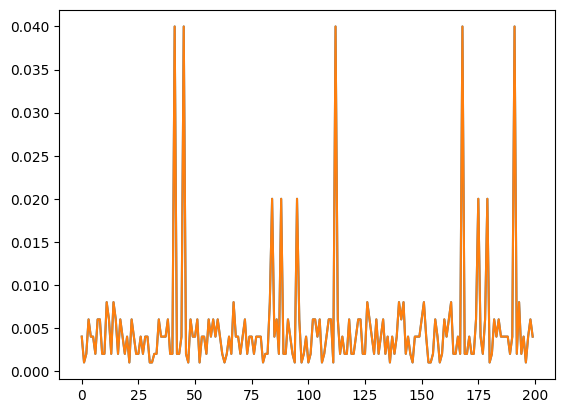

In [17]:
plt.plot(coef_train, label="train")
plt.plot(coef_validation, label="train")


## Do a check calculatingthe target based on the coeficients computed
Notice this is not a prediction because we are going to use future values to calculate the target. 
The goal here is to see how well perform the coeficients we predicted to compute the index_wap, and then, the target

### Step 1: Add stock weight to train and test df

In [18]:
train_data["weights"] = train_data["stock_id"].apply(lambda x: coef_train[x])
test_data["weights"] = test_data["stock_id"].apply(lambda x: coef_train[x])

/tmp/ipykernel_427675/672013056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["weights"] = train_data["stock_id"].apply(lambda x: coef_train[x])
/tmp/ipykernel_427675/672013056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["weights"] = test_data["stock_id"].apply(lambda x: coef_train[x])


### Step 2: Compute Index_wap

In [19]:

def compute_index(df):
    index_values = {'date_id': [], "seconds_in_bucket":[], 'index_wap': []}
    for (date, seconds_in_bucket), records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        index_values['date_id'].append(date)
        index_values['seconds_in_bucket'].append(seconds_in_bucket)
        index_values['index_wap'].append(sum(records['wap'] * records['weights']))
        
    return pd.DataFrame(index_values)


train_index = compute_index(train_data)
train_data = train_data.merge(train_index, on=['date_id', 'seconds_in_bucket'], how='left')
test_index = compute_index(test_data)
test_data = test_data.merge(test_index, on=['date_id', 'seconds_in_bucket'], how='left')

100%|██████████| 3080/3080 [00:00<00:00, 8062.87it/s]


In [20]:
train_data.count()

stock_id                           4621893
date_id                            4621893
seconds_in_bucket                  4621893
imbalance_size                     4621893
imbalance_buy_sell_flag            4621893
reference_price                    4621893
matched_size                       4621893
far_price                          4621893
near_price                         4621893
bid_price                          4621893
bid_size                           4621893
ask_price                          4621893
ask_size                           4621893
wap                                4621893
target                             4621893
time_id                            4621893
row_id                             4621893
imb_s1                             4621893
imb_s2                             4621893
reference_price_far_price_diff     4621893
reference_price_near_price_diff    4621893
reference_price_ask_price_diff     4621893
reference_price_bid_price_diff     4621893
reference_p

### Step 3: Compute target and print error

Got

2024-03-28 23:45:07 [info     ] Mean error train data          error=0.008110352923262917

2024-03-28 23:45:07 [info     ] Mean error test data           error=0.005199076166184705

Target is measured in basic points, so this error is tiny

As a consequence, coeficients appears to be meaninful

In [21]:
for label, df in zip(['train', 'test'], [train_data, test_data]):
    
    aux_df = df.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
    aux_df["wap_t+60"] = aux_df.groupby(["stock_id", "date_id"])["wap"].shift(-6)
    aux_df["index_wap_t+60"] = aux_df.groupby(["stock_id", "date_id"])["index_wap"].shift(-6)
    aux_df["predicted_target"] = ((aux_df["wap_t+60"] / aux_df["wap"]) - (aux_df["index_wap_t+60"] / aux_df["index_wap"])) * 10000

    # Measure computation error
    aux_df["error"] = abs(aux_df["predicted_target"] - aux_df["target"])
    aux_df["error"].mean()
    logger.info(f"Mean error {label} data", error=aux_df["error"].mean())


del aux_df



2024-04-05 18:31:55 [info     ] Mean error train data          error=0.015802991394335834
2024-04-05 18:31:55 [info     ] Mean error test data           error=0.012442177738671218


# Prophet Model to Predict Stock Prices

The idea here is to train prophet model for each stock and predict stock prices 

## Step 1: Train a separate model for each stock

This model will be use to predict the stock wap at t+60

In [22]:
from fbprophet import Prophet
import datetime
np.float = float

def add_ds(df, start_date=datetime.datetime(2023, 1, 1, 16, 50, 0)):
    # add time elapsed df[date_id] days  
    df["ds"] =  start_date + pd.to_timedelta(df["date_id"], unit='D') + pd.to_timedelta(df["seconds_in_bucket"], unit='S')
    return df

train_data = add_ds(train_data)
test_data = add_ds(test_data)

/home/fraverta/development/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [23]:
features

['seconds_in_bucket',
 'imbalance_buy_sell_flag',
 'imbalance_size',
 'matched_size',
 'bid_size',
 'ask_size',
 'reference_price',
 'far_price',
 'near_price',
 'ask_price',
 'bid_price',
 'wap',
 'imb_s1',
 'imb_s2',
 'reference_price_far_price_diff',
 'reference_price_near_price_diff',
 'reference_price_ask_price_diff',
 'reference_price_bid_price_diff',
 'reference_price_wap_diff',
 'far_price_near_price_diff',
 'far_price_ask_price_diff',
 'far_price_bid_price_diff',
 'far_price_wap_diff',
 'near_price_ask_price_diff',
 'near_price_bid_price_diff',
 'near_price_wap_diff',
 'ask_price_bid_price_diff',
 'ask_price_wap_diff',
 'bid_price_wap_diff']

In [24]:
import pickle

def train_prophet(df):
    features = [ 'imb_s1',  'imb_s2',  'reference_price_far_price_diff',  'reference_price_near_price_diff',  'reference_price_ask_price_diff',  'reference_price_bid_price_diff',  'reference_price_wap_diff',  'far_price_near_price_diff',  'far_price_ask_price_diff',  'far_price_bid_price_diff',  'far_price_wap_diff',  'near_price_ask_price_diff',  'near_price_bid_price_diff',  'near_price_wap_diff',  'ask_price_bid_price_diff',  'ask_price_wap_diff',  'bid_price_wap_diff']
    stock_predictors = {}
    for stock_id in tqdm(df["stock_id"].unique()):
        if os.path.exists(os.path.join(PATH_TO_PICKLE_MODELS, f"stock_{stock_id}_predictor.pkl")):
            logger.info(f"Model for stock {stock_id} already exists")
            continue
        logger.info(f"Training model for stock {stock_id}")
        stock_df = df[df["stock_id"] == stock_id][['ds', 'wap'] + features]
        stock_df.columns = ['ds', 'y'] + features    
        model = Prophet()
        
        for feature in features:
            model.add_regressor(feature)

        model.fit(stock_df)
        stock_predictors[stock_id] = model
        # pickle the model
        with open(os.path.join(PATH_TO_PICKLE_MODELS, f"stock_{stock_id}_predictor.pkl"), "wb") as f:
            pickle.dump(model, f)


    return stock_predictors

def load_prophet(df):
    stock_predictors = {}
    for stock_id in tqdm(df["stock_id"].unique()):
        with open(os.path.join(PATH_TO_PICKLE_MODELS, f"stock_{stock_id}_predictor.pkl"), "rb") as f:
           stock_predictors[stock_id] =  pickle.load(f)
    return stock_predictors


train_stock_predictors = train_prophet(train_data)

  0%|          | 0/200 [00:00<?, ?it/s]

2024-04-05 18:31:56 [info     ] Model for stock 0 already exists
2024-04-05 18:31:56 [info     ] Model for stock 1 already exists
2024-04-05 18:31:56 [info     ] Model for stock 2 already exists
2024-04-05 18:31:56 [info     ] Model for stock 3 already exists
2024-04-05 18:31:56 [info     ] Model for stock 4 already exists
2024-04-05 18:31:56 [info     ] Model for stock 5 already exists
2024-04-05 18:31:56 [info     ] Model for stock 6 already exists
2024-04-05 18:31:56 [info     ] Model for stock 7 already exists
2024-04-05 18:31:56 [info     ] Model for stock 8 already exists
2024-04-05 18:31:56 [info     ] Model for stock 9 already exists
2024-04-05 18:31:56 [info     ] Model for stock 10 already exists
2024-04-05 18:31:56 [info     ] Model for stock 11 already exists
2024-04-05 18:31:56 [info     ] Model for stock 12 already exists
2024-04-05 18:31:56 [info     ] Model for stock 13 already exists
2024-04-05 18:31:56 [info     ] Model for stock 14 already exists
2024-04-05 18:31:56 

2024-04-05 18:31:56 [info     ] Model for stock 81 already exists
2024-04-05 18:31:56 [info     ] Model for stock 82 already exists
2024-04-05 18:31:56 [info     ] Model for stock 83 already exists
2024-04-05 18:31:56 [info     ] Model for stock 84 already exists
2024-04-05 18:31:56 [info     ] Model for stock 85 already exists
2024-04-05 18:31:56 [info     ] Model for stock 86 already exists
2024-04-05 18:31:56 [info     ] Model for stock 87 already exists
2024-04-05 18:31:56 [info     ] Model for stock 88 already exists
2024-04-05 18:31:56 [info     ] Model for stock 89 already exists
2024-04-05 18:31:56 [info     ] Model for stock 90 already exists
2024-04-05 18:31:56 [info     ] Model for stock 91 already exists
2024-04-05 18:31:56 [info     ] Model for stock 92 already exists
2024-04-05 18:31:56 [info     ] Model for stock 93 already exists
2024-04-05 18:31:56 [info     ] Model for stock 94 already exists
2024-04-05 18:31:56 [info     ] Model for stock 95 already exists
2024-04-05

100%|██████████| 200/200 [00:00<00:00, 2557.92it/s]


## Step 2: Predict stock wap_t60 for test data

This predict the wap at t+60 for each stock, notice this is NOT target

In [25]:
from typing import Dict

def predict(wap_per_stock_predictors: Dict, df: pd.DataFrame):
    predictions = []
    for stock_id in tqdm(df["stock_id"].unique()):
        stock_df = df[df["stock_id"] == stock_id][['ds'] + features]
        stock_predictor = wap_per_stock_predictors[stock_id]
        forecast = stock_predictor.predict(stock_df)
        # delete every columns except ds and yhat
        forecast = forecast[['ds', 'yhat']]
        forecast["stock_id"] = stock_id
        ## replace yhat by 1 if seconds_in_bucket is 0
        #forecast.loc[forecast["ds"].dt.second == 0, "yhat"] = 1
        predictions.append(forecast)
    
    return pd.concat(predictions)

wap_per_stock_predictor = load_prophet(train_data)
test_data_with_y = test_data.iloc[:]
test_data_with_y["wap_t+60"] = test_data.groupby(["stock_id", "date_id"])["wap"].shift(-6)

test_data_with_y = test_data_with_y[~test_data_with_y["wap_t+60"].isna()]

test_predictions = predict(wap_per_stock_predictor, test_data_with_y)
test_predictions

test_with_pred = test_data_with_y.merge(test_predictions, on=['stock_id', 'ds'], how='right')
logger.info("Mean error test data", error=abs(test_with_pred["yhat"] - test_with_pred["wap_t+60"]).mean())
test_with_pred


  0%|          | 0/200 [00:00<?, ?it/s]

 56%|█████▌    | 112/200 [00:12<01:19,  1.10it/s]

: 

In [ ]:
test_with_pred.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'imb_s1', 'imb_s2',
       'reference_price_far_price_diff', 'reference_price_near_price_diff',
       'reference_price_ask_price_diff', 'reference_price_bid_price_diff',
       'reference_price_wap_diff', 'far_price_near_price_diff',
       'far_price_ask_price_diff', 'far_price_bid_price_diff',
       'far_price_wap_diff', 'near_price_ask_price_diff',
       'near_price_bid_price_diff', 'near_price_wap_diff',
       'ask_price_bid_price_diff', 'ask_price_wap_diff', 'bid_price_wap_diff',
       'weights', 'index_wap', 'ds', 'wap_t+60', 'yhat'],
      dtype='object')

# Step 3: Predict Index Wap at t+60

Based on the WAP predicted for stocks, it aggregates the predicted wap weighted by the stocks weitghts to compute the Index
Here we dont have a model it is just computing a weighted average

In [ ]:

df = compute_index(test_with_pred)
test_with_pred2 = test_with_pred.merge(df, on=['date_id', 'seconds_in_bucket'], how='left')


df = test_with_pred[['date_id', 'seconds_in_bucket', 'stock_id', 'yhat', 'weights']]
# rename column yhats to wap
df.rename(columns={'yhat': 'wap'}, inplace=True)
df = compute_index(df)
df.rename(columns={'index_wap': 'index_wap_t+60_predicted'}, inplace=True)
test_with_pred2 = test_with_pred.merge(df, on=['date_id', 'seconds_in_bucket'], how='left')

test_with_pred2

100%|██████████| 2744/2744 [00:01<00:00, 2053.45it/s]
/tmp/ipykernel_238686/1041521258.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'yhat': 'wap'}, inplace=True)
100%|██████████| 2744/2744 [00:00<00:00, 9857.35it/s]


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,near_price_wap_diff,ask_price_bid_price_diff,ask_price_wap_diff,bid_price_wap_diff,weights,index_wap,ds,wap_t+60,yhat,index_wap_t+60_predicted
0,0,425,0,7218754.93,-1,1.000062,22642235.17,0.000000,0.000000,0.999873,...,0.000000,0.000189,0.000062,-0.000127,0.004,1.000000,2024-03-01 16:50:00,1.000141,0.999903,0.999922
1,0,425,10,6166574.88,-1,1.000062,23694415.22,0.000000,0.000000,1.000062,...,0.000000,0.000190,0.000052,-0.000138,0.004,0.999861,2024-03-01 16:50:10,1.000120,1.000007,0.999943
2,0,425,20,6179553.04,-1,1.000252,23694415.22,0.000000,0.000000,1.000252,...,0.000000,0.000379,0.000197,-0.000182,0.004,0.999995,2024-03-01 16:50:20,1.000082,0.999911,0.999937
3,0,425,30,6513133.79,-1,1.000062,23694415.22,0.000000,0.000000,1.000062,...,0.000000,0.000190,0.000070,-0.000120,0.004,0.999933,2024-03-01 16:50:30,0.999920,0.999955,0.999924
4,0,425,40,6492927.96,-1,0.999873,23694415.22,0.000000,0.000000,0.999873,...,0.000000,0.000379,0.000236,-0.000143,0.004,0.999764,2024-03-01 16:50:40,0.999977,0.999847,0.999910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548794,199,480,440,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,...,-0.000193,0.000317,0.000124,-0.000193,0.004,0.998912,2024-04-25 16:57:20,1.002835,0.998920,0.999107
548795,199,480,450,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,...,-0.000168,0.000317,0.000149,-0.000168,0.004,0.998803,2024-04-25 16:57:30,1.002974,0.998853,0.999167
548796,199,480,460,135671.59,-1,1.001812,23784351.66,1.001177,1.001812,1.001812,...,-0.000161,0.000317,0.000156,-0.000161,0.004,0.998888,2024-04-25 16:57:40,1.001982,0.998814,0.999379
548797,199,480,470,796236.05,-1,1.001812,23788288.28,1.001177,1.001494,1.001812,...,-0.000440,0.000317,0.000195,-0.000122,0.004,0.998825,2024-04-25 16:57:50,1.001993,0.998682,0.999392


## Predict target based on the stock and index wap predicted

In [ ]:
def predict_target(df: pd.DataFrame):
    df["predicted_target"] = ((df["yhat"] / df["wap"]) - (df["index_wap_t+60_predicted"] / df["index_wap"])) * 10000
    df["error"] = abs(df["predicted_target"] - df["target"])

    logger.info("Mean error test data", error=(df['predicted_target'] - df['target']).abs().mean())
    return df


predict_target(test_with_pred2)
# print to csv
test_with_pred2.to_csv("test_with_pred2.csv", index=False)

2024-03-30 01:50:07 [info     ] Mean error test data           error=14.167444718200379


: 